# Use to explore and find issues with registry metadata

## Setup

In [1]:
## CX: allows multiple lines of code to print from one code block
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## show time that this notebook was executed 
from datetime import datetime

## packages to work with objects 
import re
import requests
import pandas as pd
from textwrap import wrap  ## for plot labels

## to get around bugs
import nest_asyncio
nest_asyncio.apply()

In [2]:
## record when cell blocks are executed
print('The time that this notebook was executed is...')
print('Local time (PST, West Coast USA): ')
print(datetime.now())
print('UTC time: ')
print(datetime.utcnow())

The time that this notebook was executed is...
Local time (PST, West Coast USA): 
2021-02-04 21:11:02.953915
UTC time: 
2021-02-05 05:11:02.954055


### Getting and parsing registry info

In [12]:
## setup request
headers = {"content-type": "application/json"}
registry_url = "https://smart-api.info/api/query/?q=%22%22&fields=info%2Ctags%2C_meta.uptime_status&raw=1&size=1000"

## make request: check for success (200)
registry_request = requests.get(registry_url, headers=headers)
registry_request.status_code

200

In [13]:
registry = registry_request.json()

In [14]:
registry['hits']['hits'][0]

{'_index': 'smartapi_oas3',
 '_type': 'api',
 '_id': '3a43d2dc3b142b2127234be318970693',
 '_score': 3.7511036,
 '_source': {'_meta': {'uptime_status': 'incompatible'},
  'info': {'title': 'FAIRsharing API', 'version': ''}}}

In [17]:
## get response
registry = registry_request.json()

## parse response to get the information: uptime status, tags, x-translator, api name
registry_data = []
for ele in registry['hits']['hits']:
    tempDict = {'uptimeStatus': ele['_source']['_meta']['uptime_status'],
                'name': ele['_source']['info']['title']}
    
    if ele['_source'].get('tags'):
        temp = [i.get('name') for i in ele['_source']['tags']]
        tempDict.update({"tags": temp})
    else:
        tempDict.update({"tags": []})
    
    if ele['_source']['info'].get('x-translator'):
        tempDict.update({            
            'team': ele['_source']['info']['x-translator'].get('team'),
            'component': ele['_source']['info']['x-translator'].get('component')
        })
    else:
        tempDict.update({            
            'team': [],
            'component': None
        })
    registry_data.append(tempDict)

In [38]:
registry_df = pd.DataFrame.from_dict(registry_data)
registry_df = registry_df[['name', 'team', 'component', 'uptimeStatus', 'tags']]
registry_df.shape

(216, 5)

### Issues around duplicate entries / x-translator compliance

In [51]:
## allow these entries' team value (currently not in enum)
registry_df[registry_df['name'].str.contains('Ontology-KP')]
registry_df[registry_df['name'].str.contains('imProving')]

,name,team,component,uptimeStatus,tags
15,Ontology-KP API,SRI,KP,unknown,[translator]


,name,team,component,uptimeStatus,tags
25,imProving Agent,[imProving Agent],ARA,unknown,"[predicates, query, translator, reasoner, SPOKE]"


In [40]:
## note the first entry doesn't have an allowed enum name (only Genetics Provider was allowed)
## also, two different TRAPI versions?
registry_df[registry_df['name'].str.contains('Genetics')]

,name,team,component,uptimeStatus,tags
27,Genetics Provider,"[Genetics Provider, Broad Institute Flannick Lab]",KP,unknown,"[1.0.0, translator, x-translator, reasoner, me..."
159,Genetics Provider API,[Genetics Provider],KP,unknown,"[0.9.2, translator, reasoner]"


In [41]:
## looks like accidentally two identical registrations? 
## see http://smart-api.info/registry?q=855adaa128ce5aa58a091d99e520d396 vs 
## http://smart-api.info/registry?q=da159a55e799a163ee23783edcb11725
registry_df[registry_df['name'].str.startswith('Connections')]

,name,team,component,uptimeStatus,tags
112,Connections Hypothesis Provider API,[Connections Hypothesis Provider],KP,unknown,"[bayesian, translator, 1.0.0]"
119,Connections Hypothesis Provider API,[Connections Hypothesis Provider],KP,unknown,"[bayesian, translator, 1.0.0]"


In [22]:
## are these two different TRAPI versions? What's going on here?
registry_df[registry_df['name'].str.startswith('Clinical Risk')]

,name,team,component,uptimeStatus,tags
150,Clinical Risk KP API,"[Multiomics Provider, Service Provider]",KP,good,"[disease, association, annotation, query, tran..."
215,Clinical Risk KP API,"[Multiomics Provider, Service Provider]",KP,good,"[disease, drug, chemical_substance, phenotypic..."


In [23]:
## these two versions are RENCI only vs annotated with BTE as well
registry_df[registry_df['name'].str.contains('CORD19|Cord19')]
registry_df[registry_df['name'].str.contains('PHAROS|Pharos')]
registry_df[registry_df['name'].str.startswith('Automat HMDB')]

,name,team,component,uptimeStatus,tags
70,Automat Cord19 Scibite,[Ranking Agent],KP,good,"[translator, automat]"
126,Automat CORD19 Scibite API,[Ranking Agent],KP,good,"[drug, gene, disease, automat, translator]"
182,Automat Cord19 Scigraph,[Ranking Agent],KP,good,"[translator, automat]"
203,Automat CORD19 Scigraph API,[Ranking Agent],KP,good,"[drug, gene, disease, automat, translator]"


,name,team,component,uptimeStatus,tags
43,Automat PHAROS API,[Ranking Agent],KP,good,"[drug, gene, disease, automat, translator]"
144,Automat Pharos,[Ranking Agent],KP,good,"[translator, automat]"


,name,team,component,uptimeStatus,tags
80,Automat HMDB,[Ranking Agent],KP,good,"[translator, automat]"
94,Automat HMDB API,[Ranking Agent],KP,good,"[drug, gene, disease, automat, translator]"


In [24]:
## these two versions were....registered by diff people?
registry_df[registry_df['name'].str.startswith('MyGene.info')]
registry_df[registry_df['name'].str.startswith('MyVariant.info')]

,name,team,component,uptimeStatus,tags
49,MyGene.info API,[Service Provider],KP,unknown,"[gene, annotation, query, translator]"
71,MyGene.info API (for test),[],None,unknown,[Genes]
81,MyGene.info API,[Service Provider],KP,good,"[gene, annotation, query, translator, biothings]"


,name,team,component,uptimeStatus,tags
48,MyVariant.info API,[Service Provider],KP,unknown,"[variant, annotation, query, translator]"
149,MyVariant.info API,[Service Provider],KP,good,"[variant, query, metadata, translator, biothings]"


In [25]:
## currently not a problem since changed schema to allow team to be a string 
##   (as long as it matches one of the enums)
teamNotList = [True if not isinstance(x, list) else False for x in registry_df['team']]
registry_df[teamNotList]

,name,team,component,uptimeStatus,tags
9,CAM-KP API,Exposures Provider,KP,unknown,[translator]
10,SmartAPI API,Service Provider,Utility,good,"[api, metadata, openapi, translator]"
15,Ontology-KP API,SRI,KP,unknown,[translator]
189,ARAX Translator Reasoner,Expander Agent,ARA,good,"[predicates, query, translator, reasoner, resp..."


### Finishing that parsing

Having team as an array is good when there is more than one team involved in making the API (this happens often with Service Provider). 

Having team (and tags) as an array is bad when you want to group-by/summarize....so for now I turned them to strings

In [52]:
## changing the column to strings to make it easier to sort values
registry_df['team'] = [",".join(x) if isinstance(x, list) else x for x in registry_df['team']]
registry_df['tags'] = [",".join(x) if isinstance(x, list) else x for x in registry_df['tags']]

## replacing empty strings with None
registry_df['team'] = [None if not x else x for x in registry_df['team']]
registry_df['tags'] = [None if not x else x for x in registry_df['tags']]

### Getting and parsing metaKG info

The MetaKG is currently based on annotations from x-bte. The operations are all from APIs tagged translator 

In [53]:
headers = {"content-type": "application/json"}

metaKG_url = "https://smart-api.info/api/metakg"

metaKG_request = requests.get(metaKG_url, headers=headers)
metaKG_request.status_code
## if the output is successful, code 200

200

In [54]:
metaKG = metaKG_request.json()

In [55]:
metaKG_operations = []
for edge in metaKG['associations']:
    tempdict = {
        "subject": edge['subject'],
        "object": edge['object'],
        "predicate": edge['predicate'],
        "provided_by": edge.get('provided_by'),
        "api_name": edge['api']['name']
    }
    if edge['api'].get('x-translator'):
        tempteam = edge['api']['x-translator'].get('team')
        if isinstance(tempteam, list):
            tempteam = ",".join(tempteam)
            if not tempteam:
                tempteam = None  
        tempdict.update({
            "api_team": tempteam,
            "api_component": edge['api']['x-translator'].get('component'),
        })
    else:
        tempdict.update({
            "api_team": None,
            "api_component": None,
        })
    metaKG_operations.append(tempdict)

In [56]:
operations_summary = pd.DataFrame.from_dict(metaKG_operations)
operations_summary.shape
## describes this many operations

(8475, 7)

### Issues around metaKG metadata

So....why are there so many ARA operations? The metaKG is currently based in KP operations, right?

In [57]:
operations_summary.api_component.value_counts()

ARA    7115
KP     1360
Name: api_component, dtype: int64

So....The ARA with >7000 operations is ARAX. 

Questions around whether there REALLY are associations for all subject-object type pairs in the other top KP APIs. 

In [58]:
operations_summary.api_name.value_counts()

ARAX Translator Reasoner                                             7072
Clinical Risk KP API                                                  308
Text Mining CO-OCCURRENCE API                                         288
Multiomics Wellness KP API                                            128
SEMMED Disease API                                                     96
SEMMED Chemical API                                                    93
SEMMED Gene API                                                        74
SEMMED Phenotype API                                                   73
SEMMED Biological Process API                                          67
imProving Agent                                                        43
SEMMED Anatomy API                                                     37
BioLink API                                                            18
Molecular Data Provider for NCATS Biomedical Translator Reasoners      17
mydisease.info API                    

## Registry API-level summary

### Comparing translator tag and x-translator use

In [59]:
registry_df['hasTranslatorTag'] =  [False if x is None else x for x in registry_df.tags.str.contains('translator')]
registry_df['hasXTranslator'] =  [False if x is None else True for x in registry_df.team]
registry_df[['hasTranslatorTag', 'hasXTranslator']].value_counts().reset_index(name = "Num of APIs")

,hasTranslatorTag,hasXTranslator,Num of APIs
0,False,False,113
1,True,True,88
2,True,False,14
3,False,True,1


So there are 102 APIs with the "translator" tag, and 88 of them currently have the x-translator extension. There is one API with the x-translator extension and no "translator" tag. 

### Translator-tagged / x-translator APIs

In [60]:
## grab only the APIs with the translator tag 
translator_apis = registry_df[(registry_df['hasTranslatorTag']) | 
            (registry_df['hasXTranslator'])].copy()
translator_apis.drop(columns = ['hasTranslatorTag'], inplace = True)
translator_apis = translator_apis[['team', 'component', 'name', 'uptimeStatus', 'tags']]
translator_apis.sort_values(by=['team', 'component', 'name'], 
                            ignore_index = True, na_position = 'last', inplace = True)

Translator-tagged APIs with x-translator information. Another review may need to be done to address duplicate API registrations / different API registrations for BTE. 

In [62]:
summarytable1 = translator_apis[~ translator_apis['team'].isna()].copy()
summarytable1

,team,component,name,uptimeStatus,tags
0,Clinical Data Provider,KP,Columbia Open Health Data (COHD),good,"Metadata,OMOP,Clinical Frequencies,Concept Ass..."
1,Clinical Data Provider,KP,Columbia Open Health Data (COHD) for COVID-19 ...,good,"Metadata,OMOP,Clinical Frequencies,Concept Ass..."
2,Clinical Data Provider,KP,OpenPredict API 🔮🐍,good,"translator,reasoner"
3,Clinical Data Provider,KP,Translator Knowledge Collaboratory API,good,"predicates,query,translator,reasoner"
4,Connections Hypothesis Provider,KP,Connections Hypothesis Provider API,unknown,"bayesian,translator,1.0.0"
...,...,...,...,...,...
84,Standards Reference Implementation Team,Utility,Name Resolver,unknown,translator
85,Standards Reference Implementation Team,Utility,Node Normalization,good,Interfaces
86,"Text Mining Provider,Service Provider",KP,Text Mining CO-OCCURRENCE API,good,"gene,chemical,association,annotation,query,tra..."
87,"Text Mining Provider,Service Provider",KP,Text Mining Targeted Association API,good,"gene,chemical,association,annotation,query,tra..."


The APIs WITHOUT x-translator information

In [61]:
## APIs without x-translator information
summarytable2 = translator_apis[translator_apis['team'].isna()].copy()
summarytable2

,team,component,name,uptimeStatus,tags
89,None,None,Big GIM(Gene Interaction Miner),unknown,"translator,ISB,gene,similarity,tissue,TCGA,GIA..."
90,None,None,Broad probabilistic graphical models translator,unknown,translator
91,None,None,CMAQ Exposures API,incompatible,translator
92,None,None,ChEMBL API,good,"publication,translator"
93,None,None,Metadata Provider API,good,"metadata,biosample,translator"
94,None,None,NCATS ARA Scaffold,unknown,translator
95,None,None,NCATS KP Scaffold,unknown,translator
96,None,None,OpenAPI for indigo NCATS Biomedical Translator...,unknown,"query,translator,reasoner"
97,None,None,RGD API,good,"translator,gene"
98,None,None,ROBOKOP,good,"translator,reasoner"


#### APIs by team

<AxesSubplot:title={'center':'Num of APIs by team'}>

,name,Num of APIs
0,Ranking Agent,32
1,Service Provider,29
2,Standards Reference Implementation Team,6
3,"Multiomics Provider,Service Provider",5
4,Clinical Data Provider,4
5,"Text Mining Provider,Service Provider",2
6,Connections Hypothesis Provider,2
7,Explanatory Agent,1
8,Genetics Provider,1
9,imProving Agent,1


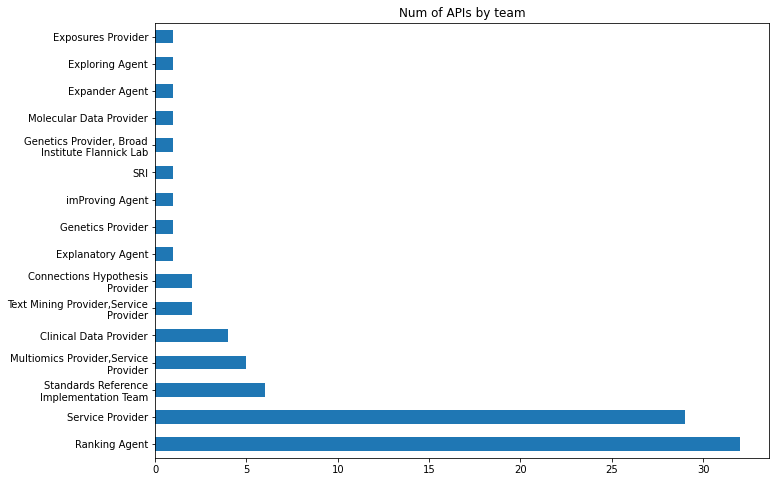

In [63]:
team_summary = translator_apis.team.value_counts().reset_index()
team_summary.columns = ['name', 'Num of APIs']
team_summary['plot_names'] = [ '\n'.join(wrap(i, 30)) for i in team_summary['name']]

team_summary.plot.barh(x='plot_names', y='Num of APIs', fontsize = 10, figsize=(11,8), rot=0, 
                       legend=False, title = "Num of APIs by team", xlabel="")
## table view
team_summary[['name', 'Num of APIs']]

#### APIs by component

,index,component
0,KP,76
1,ARA,8
2,Utility,5


<AxesSubplot:title={'center':'Num of APIs by team'}>

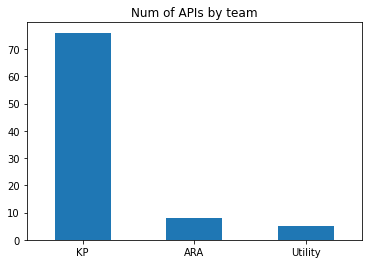

In [64]:
component_summary = translator_apis.component.value_counts().reset_index()
component_summary
component_summary.plot.bar(x='index', y='component', rot=0,
                       legend=False, title = "Num of APIs by team", xlabel="")

#### APIs by uptime status

,index,uptimeStatus
0,good,76
1,unknown,24
2,incompatible,3


<AxesSubplot:title={'center':'Num of APIs by team'}>

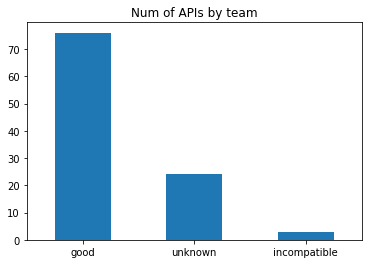

In [65]:
status_summary = translator_apis.uptimeStatus.value_counts().reset_index()
status_summary
status_summary.plot.bar(x='index', y='uptimeStatus', rot=0,
                       legend=False, title = "Num of APIs by team", xlabel="")

## using x-translator and metaKG together

The MetaKG is currently based on annotations from x-bte. The operations are all from APIs tagged translator 

### predicates by team

In [66]:
operations1 = operations_summary[['predicate', 'api_name', 'api_team']].drop_duplicates()
operations1.api_team.value_counts().reset_index(name = 'Num of unique predicates')

,index,Num of unique predicates
0,Service Provider,161
1,Expander Agent,79
2,imProving Agent,24
3,Molecular Data Provider,10
4,"Multiomics Provider,Service Provider",7
5,"Text Mining Provider,Service Provider",5
6,Clinical Data Provider,5
7,Ranking Agent,5
8,Standards Reference Implementation Team,3
9,"Genetics Provider, Broad Institute Flannick Lab",3
